In [6]:
!nvidia-smi

Wed Oct 19 21:25:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:09:00.0 Off |                  N/A |
| 39%   68C    P2   104W / 250W |  10340MiB / 11019MiB |     72%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:0A:00.0 Off |                  N/A |
| 50%   

In [2]:
#%%capture
#!pip uninstall -y transformers torch
#!conda install -y pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
#!conda uninstall -y -c huggingface transformers datasets
#!conda uninstall -y -c huggingface transformers datasets

In [3]:
!pip uninstall -y umap
!pip install umap-learn

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_PATH'] = '/usr/local/cuda-10.0'

import transformers
import datasets

#print(f"Running on transformers v{transformers.version} and datasets v{datasets.version}")

## Imports

In [5]:
import torch
from pathlib import Path
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer)

import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm

In [6]:
form = 'red2'
label_len = 20

In [7]:
import json
import pandas as pd

with open('baseline/citation_map.json', 'r') as f:
    label_dict = json.loads(f.readline())
citations = list(label_dict.items())
citations

[('42_1983_', 0),
 ('11_523_(a)', 1),
 ('28_1331_', 2),
 ('28_157_(b)', 3),
 ('42_1981_', 4),
 ('28_1332_', 5),
 ('28_636_(b)', 6),
 ('42_2000e_', 7),
 ('11_101_', 8),
 ('28_2254_', 9),
 ('42_405_(g)', 10),
 ('28_2255_', 11),
 ('42_1988_', 12),
 ('28_1404_(a)', 13),
 ('5_706_', 14),
 ('28_1334_', 15),
 ('28_2254_(d)', 16),
 ('29_1132_(a)', 17),
 ('11_362_(a)', 18),
 ('18_3553_(a)', 19),
 ('42_1985_', 20),
 ('21_841_(a)', 21),
 ('18_1961_', 22),
 ('28_2201_', 23),
 ('29_1002_', 24),
 ('11_727_(a)', 25),
 ('18_922_(g)', 26),
 ('5_552_(b)', 27),
 ('28_1343_', 28),
 ('11_362_', 29),
 ('28_1291_', 30),
 ('15_1_', 31),
 ('11_541_(a)', 32),
 ('15_1125_(a)', 33),
 ('29_1001_', 34),
 ('28_1332_(a)', 35),
 ('28_1334_(b)', 36),
 ('35_112_', 37),
 ('28_1447_(c)', 38),
 ('28_1367_(c)', 39),
 ('15_78j_(b)', 40),
 ('18_924_(c)', 41),
 ('28_1346_(b)', 42),
 ('11_1325_(a)', 43),
 ('28_1367_', 44),
 ('28_1292_(b)', 45),
 ('28_1441_', 46),
 ('28_2241_', 47),
 ('28_1738_', 48),
 ('11_547_(b)', 49),
 ('42_

In [8]:
defs = []
for i in range(20):
    with open('baseline/definitions/{0}-{1}.json'.format(citations[i][1], citations[i][0]), 'r') as f:
        defs.append(f.readline())
defs

["   Every person who, under color of any statute, ordinance, regulation, custom, or usage, of any State or Territory or the District of Columbia, subjects, or causes to be subjected, any citizen of the United States or other person within the jurisdiction thereof to the deprivation of any rights, privileges, or immunities secured by the Constitution and laws, shall be liable to the party injured in an action at law, suit in equity, or other proper proceeding for redress, except that in any action brought against a judicial officer for an act or omission taken in such officer's judicial capacity, injunctive relief shall not be granted unless a declaratory decree was violated or declaratory relief was unavailable. For the purposes of this section, any Act of Congress applicable exclusively to the District of Columbia shall be considered to be a statute of the District of Columbia.  (R.S. § 1979; Pub. L. 96–170, § 1, Dec. 29, 1979, 93 Stat. 1284; Pub. L. 104–317, title III, § 309(c), Oct

In [9]:
uscode_reg = r'(?<=\s)([\d]+[a-z]*)\s+U.S.C. §+ (([0-9]+[a-z]*[-–]*)+)(\(([a-z])\))*(\(([\d])\))*'
precedence_reg = r'[0-9]{3} .*?\([0-9]{4}\)'

date_reg = r'. ([A-Z]{1}[a-z]+ [0-9]{1,2}, [0-9]{4})'

def preprocess(to_extract):
    codes = []
    #parser.parse(to_extract[:500], fuzzy=True)
    date_str = re.search(date_reg, to_extract[:500])
    try:
        date = datetime.datetime.strptime(spell(date_str.group(1)), '%B %d, %Y')
    except Exception as e:
        date = None
    
    c = re.finditer(uscode_reg, to_extract)
    masked = to_extract
#     citations = get_citations(to_extract)
    if c:
        for code in c:
            token = 'USC_{0}'.format(code.group(1), code.group(2), code.group(5))
            
            if int(re.sub('[^0-9]', '', code.group(1))) < 100:
                #token = code
                codes.append(code.group(0))
                #masked = masked.replace(code.group(0), ' <mask>')
                to_extract = to_extract.replace(code.group(0), ' ')
                
            else:
                masked = masked.replace(code.group(0), ' ')
                to_extract = to_extract.replace(code.group(0), ' ')
    
    to_extract = re.sub(precedence_reg, ' ', to_extract)
    to_extract = re.sub(r'(\<\/*[a-z0-9 ="-]*\>)', ' ', to_extract)
    to_extract = re.sub(r'(\[[0-9]+\])', ' ', to_extract)
    to_extract = to_extract.replace('&amp', '&')
    to_extract = to_extract.replace(r'[\n\[\]]', ' ')
    to_extract = re.sub(r'\([A-Za-z0-9]+\)', ' ', to_extract)
    to_extract = to_extract.encode('ascii', errors='ignore').decode()
    to_extract = re.sub(r'[\s]{2,}', '', to_extract)
    
    return [to_extract, masked, codes, date, len(to_extract)]

In [10]:
defs = []
for i in range(20):
    with open('baseline/definitions/{0}-{1}.json'.format(citations[i][1], citations[i][0]), 'r') as f:
        defs.append(f.readline())
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

defs_cleaned = []
def_tokens = []
for d in defs:
    to_extract = preprocess(d)[0]
    defs_cleaned.append(to_extract)

    to_extract = tokenizer(to_extract, max_length=512, truncation=True, padding='max_length', return_tensors='pt')['input_ids']
    def_tokens.append(to_extract)
    #print(to_extract.shape)
    
defs_cleaned

["Every person who, under color of any statute, ordinance, regulation, custom, or usage, of any State or Territory or the District of Columbia, subjects, or causes to be subjected, any citizen of the United States or other person within the jurisdiction thereof to the deprivation of any rights, privileges, or immunities secured by the Constitution and laws, shall be liable to the party injured in an action at law, suit in equity, or other proper proceeding for redress, except that in any action brought against a judicial officer for an act or omission taken in such officer's judicial capacity, injunctive relief shall not be granted unless a declaratory decree was violated or declaratory relief was unavailable. For the purposes of this section, any Act of Congress applicable exclusively to the District of Columbia shall be considered to be a statute of the District of Columbia.(R.S.1979; Pub. L. 96170,1, Dec. 29, 1979, 93 Stat. 1284; Pub. L. 104317, title III,309 , Oct. 19, 1996, 110 St

## Load data

In [11]:
test_enc_1 = load_dataset('json', data_files=f'data/{form}/testenc-{label_len}.json', split='train[:50%]')
test_enc_2 = load_dataset('json', data_files=f'data/{form}/testenc-{label_len}.json', split='train[50%:]')
val_enc = load_dataset('json', data_files=f'data/{form}/valenc-{label_len}.json', split='train')
train_enc = load_dataset('json', data_files=f'data/{form}/trainenc-{label_len}.json', split='train')

Using custom data configuration default-1b256f785299c53d
Reusing dataset json (/home/14cfl/.cache/huggingface/datasets/json/default-1b256f785299c53d/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)
Using custom data configuration default-1b256f785299c53d
Reusing dataset json (/home/14cfl/.cache/huggingface/datasets/json/default-1b256f785299c53d/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)
Using custom data configuration default-8f7ca6502bf40e42
Reusing dataset json (/home/14cfl/.cache/huggingface/datasets/json/default-8f7ca6502bf40e42/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)
Using custom data configuration default-4762cebe3660c3fe
Reusing dataset json (/home/14cfl/.cache/huggingface/datasets/json/default-4762cebe3660c3fe/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)


#### TO DO:
- retrieve definition text from citations
- tokenize and encode citation definition, incorporate into prototypes
*- write prototype update code

In [12]:
import torch.nn.functional as F
#from sentence_transformers import util
from torch import nn

from transformers.modeling_outputs import SequenceClassifierOutput


In [13]:
from utils import PrototypeCallback, PrototypeTrainer, CustomMetrics
#from prototype_model import PrototypeModel

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [14]:
import torch.nn.functional as F
#from sentence_transformers import util
from torch import nn

from transformers.modeling_outputs import SequenceClassifierOutput

class PrototypeModel(transformers.PreTrainedModel):

    def __init__(self, roberta, config, num_prototypes_per_class, definitions=None, N_input=1, N_output=100):
        super(PrototypeModel, self).__init__(config)
        
        self.roberta = roberta
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        
        self.num_labels = N_output
        self.clst = 0.10
        self.sep = 0.05
        
        # prototype layers
        self.epsilon = 1e-4
        self.prototype_shape = (N_output * num_prototypes_per_class, 768)
        self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
                                              requires_grad=True)
        self.prototype_sample = nn.Parameter(torch.zeros(N_output, num_prototypes_per_class, 512))
        #print(definitions)
        self.definition_tokens = definitions
        with torch.no_grad():
            self.definitions = nn.Parameter(self.roberta(definitions).last_hidden_state[:,0,:])
        
        self.num_prototypes = self.prototype_shape[0]
        self.last_layer = nn.Linear(self.num_prototypes, N_output,
                                    bias=False)  # do not use bias
        assert (self.num_prototypes % N_output == 0)
        
        # a onehot indication matrix for each prototype's class identity
        self.prototype_class_identity = torch.zeros(self.num_prototypes,
                                                    N_output)
        for j in range(self.num_prototypes):
            self.prototype_class_identity[j, j // num_prototypes_per_class] = 1
        # initialize the last layer
        self.set_last_layer_incorrect_connection(incorrect_strength=-0.5)

    def set_last_layer_incorrect_connection(self, incorrect_strength):
        '''
        the incorrect strength will be actual strength if -0.5 then input -0.5
        '''
        positive_one_weights_locations = torch.t(self.prototype_class_identity)
        negative_one_weights_locations = 1 - positive_one_weights_locations

        correct_class_connection = 1
        incorrect_class_connection = incorrect_strength
        self.last_layer.weight.data.copy_(
            correct_class_connection * positive_one_weights_locations
            + incorrect_class_connection * negative_one_weights_locations)

        
    def prototype_distances(self, x, prototype_vectors): # if definition is close to a prototype, clustering loss should be higher
        # scale by/change power/add as a lambda cosine similarity to the definition
        xp = torch.mm(x, torch.t(prototype_vectors))
        distance = -2 * xp + torch.sum(x ** 2, dim=1, keepdim=True) + torch.t(
            torch.sum(prototype_vectors ** 2, dim=1, keepdim=True))
        similarity = torch.log((distance + 1) / (distance + self.epsilon))
        return similarity, distance

    def forward(self, input_ids, attention_mask, labels=None):
        #print(input_ids.shape)
        X = self.roberta(input_ids = input_ids, attention_mask = attention_mask)
        #print(X.hidden_states[-1].shape)
        embed = X.last_hidden_state[:,0] # encoding of CLS token as a baseline for computation cost
        
        #print(x.shape, embed.shape)
        prototype_activations, min_distances = self.prototype_distances(embed, self.prototype_vectors)
        def_activations, def_min_distances = self.prototype_distances(embed, self.definitions.to(device))
        #print(prototype_activations.shape)
        logits = self.last_layer(prototype_activations.view(prototype_activations.size(0), -1))
        #print(logits.shape)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return SequenceClassifierOutput(logits=(embed, logits, def_activations), loss=loss, hidden_states=(X.last_hidden_state, min_distances, def_min_distances))
    

In [15]:
from transformers import Trainer, TrainerCallback
from pykeops.torch import LazyTensor
import matplotlib.pyplot as plt

class InferenceCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, model, train_dataloader, **kwargs):
        
        control.should_training_stop = True # i just want to load the best model fr
        

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        
        
        outputs = model(**inputs)
        logits = outputs.logits[1]
        
        #print(labels.shape, logits.shape)
        min_distances = outputs.hidden_states[1]
        
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.num_labels), 
                        labels.float().view(-1, self.model.num_labels))
        #cluster loss
        
        labs = (labels == 1).nonzero()
        
        prototypes_of_correct_class = torch.t(self.model.prototype_class_identity[:, [x[1] for x in labs]]).to(self.model.device)
        query = torch.zeros(labels.size(0), prototypes_of_correct_class.size(1)).to(device)

        for i in range(labels.size(0)): # for each sample in batch
            for j in range(len(prototypes_of_correct_class)): # for each prototype of the gold label
                if labs[j][0] == i: # for each gold label, if the prototype is correct
                    query[i] = query[i] + prototypes_of_correct_class[j]
        
        prototypes_of_correct_class = query
        
        cluster_cost = torch.mean(torch.min(min_distances * prototypes_of_correct_class, dim=1)[0])

        #seperation loss
        prototypes_of_wrong_class = 1 - prototypes_of_correct_class
        separation_cost = -torch.mean(torch.min(min_distances * prototypes_of_wrong_class, dim=1)[0])

        #sparsity loss
        l1_mask = 1 - torch.t(self.model.prototype_class_identity).to(self.model.device)
        l1 = (self.model.last_layer.weight * l1_mask).norm(p=1)

        #diversity loss
        ld = 0
        for k in range(self.model.num_labels):
            p = self.model.prototype_vectors[k*self.model.num_prototypes: (k+1)*self.model.num_prototypes]
            p = F.normalize(p, p=2, dim=1)
            matrix1 = torch.mm(p, torch.t(p)) - torch.eye(p.shape[0]).to(self.model.device) - 0.3
            matrix2 = torch.zeros(matrix1.shape).to(self.model.device)
            ld += torch.sum(torch.where(matrix1 > 0, matrix1, matrix2))
        
        # definition loss
        def_min_distances = torch.t(outputs.logits[2])
        match = torch.mm(labels, def_min_distances) # version 1: only taking cosine similarity of the gold label citations
        l_def = torch.mean(match)
        
        loss = loss + self.model.clst*cluster_cost + self.model.sep*separation_cost + 5e-4 * l1 + 0.00 * ld + self.model.clst*l_def #add term for cosine similarity to definition
        
        
        
        return (loss, outputs) if return_outputs else loss
        
    

In [16]:
from sklearn.metrics import f1_score, recall_score, precision_score, hamming_loss

def customMetrics(ep):
    #custom softmax
    print(ep.predictions[0])
    if len(ep.predictions[0][1]) > 1:
        m = np.max(ep.predictions[0][1],axis=1,keepdims=True) #returns max of each row and keeps same dims
    else:
        m = np.max(ep.predictions[0][1])
    e_x = np.exp(ep.predictions[0][1] - m) #subtracts each row with its max value
    s = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / s 
    
    pred_round = np.round(f_x)
    print(pred_round, ep.label_ids)
    pred = pred_round == ep.label_ids[:len(pred_round)]
    
    negatives = np.logical_not(ep.label_ids[:len(pred)])
    guess = np.logical_and(pred, ep.label_ids[:len(pred)])
    not_cite = np.logical_and(pred, negatives)
    #print(np.sum(pred), np.sum(ep.label_ids[:len(pred)]), guess, not_cite)
    return {'tp': int(np.sum(guess.astype(float))),
           'fn': (int(np.sum(ep.label_ids[:len(pred)])) - int(np.sum(guess.astype(float)))),
            'tn': int(np.sum(not_cite.astype(float))),
           'fp': (int(np.sum(negatives)) - int(np.sum(not_cite.astype(float)))),
            'macro-f1': f1_score(ep.label_ids.astype(np.float16), pred_round, average='macro'),
            'macro-r': recall_score(ep.label_ids.astype(np.float16), pred_round, average='macro'),
            'macro-p': precision_score(ep.label_ids.astype(np.float16), pred_round, average='macro'),
            'micro-f1': f1_score(ep.label_ids.astype(np.float16), pred_round, average='micro'),
            'hamming': hamming_loss(ep.label_ids.astype(np.float16), pred_round)
           }

In [17]:
from transformers import AutoModel,AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torchinfo import summary
device = 'cuda'
model_ckpt = 'baseline/baseline-red2-20/checkpoint-11000/'

model = AutoModel.from_pretrained(model_ckpt).to(device)

model = PrototypeModel(model,config=transformers.AutoConfig.from_pretrained(model_ckpt), N_input=768, N_output=20, definitions=torch.stack(def_tokens).squeeze().to(device), num_prototypes_per_class=5)

#out = model(sample, )
summary(model)

Some weights of the model checkpoint at baseline/baseline-red2-20/checkpoint-11000/ were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at baseline/baseline-red2-20/checkpoint-11000/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Layer (type:depth-idx)                                       Param #
PrototypeModel                                               --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   38,603,520
│    │    └─Embedding: 3-2                                   394,752
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─BCEWithLogitsLoss: 1-2                                     --
├─Lin

In [18]:
batch_size = 8
run_name = 'delete me'

args = TrainingArguments(
    output_dir="prototype-red2-20-defs",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    do_eval=True,
    logging_first_step=False,
    logging_steps=500,
    dataloader_num_workers=16,
    do_train=True,
    fp16=True,
    run_name = run_name,
    eval_accumulation_steps=100,
    save_total_limit = 5,
    ignore_data_skip=True# Only last 5 models are saved. Older ones are deleted.
)
#del trainer
trainer = CustomTrainer(model=model, 
                  args=args, 
                  train_dataset=train_enc, 
                  eval_dataset=val_enc, 
                  tokenizer=tokenizer, 
                  callbacks=[InferenceCallback()],
                        compute_metrics=customMetrics
                 )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using amp half precision backend


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
trainer.train(resume_from_checkpoint=True)

Loading model from prototype-red2-20-defs/checkpoint-51500).
/home/14cfl/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 90243
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 225620
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 51500
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: chufeiluo (biases). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss


	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from prototype-red2-20-defs/checkpoint-50000 (score: 0.17709703743457794).


TrainOutput(global_step=51501, training_loss=1.8813554362110419e-06, metrics={'train_runtime': 7.6964, 'train_samples_per_second': 234505.853, 'train_steps_per_second': 29314.856, 'total_flos': 1.0858062250160947e+17, 'train_loss': 1.8813554362110419e-06, 'epoch': 4.0})

In [20]:
dl = torch.utils.data.DataLoader(train_enc, batch_size=8)

In [21]:
import umap

from sklearn.manifold import TSNE

dim_reduc = umap.UMAP(random_state=10, metric='euclidean')

def plot_umap(normalized_df, colour, prototypes, name, definitions=None):
    standard_embedding = dim_reduc.fit_transform(normalized_df)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=colour, cmap='YlGnBu', s=1)
    
    prot_embedding = dim_reduc.transform(prototypes)
    
    plt.scatter(prot_embedding[:, 0], prot_embedding[:, 1], color='r', s=5)
    
    if definitions is not None:
        def_embedding = dim_reduc.transform(definitions)
        plt.scatter(def_embedding[:, 0], def_embedding[:, 1], color='m', s=5)
    
    plt.savefig(name, dpi=200, bb_inches='tight')
    plt.show()

def plot_tsne(normalized_df, colour):
    standard_embedding = TSNE(n_components=2, perplexity=8, learning_rate='auto',init='random').fit_transform(normalized_df)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=colour, s=1, cmap='bwr')


20 cuda:0


obtaining hidden states:   0%|          | 0/11281 [00:00<?, ?it/s]

plotting data points
prototypes:
<s>Christopher R.J. Pace, Weil Gotshal &; Manges, LLP, Miami, FL (argued), Dean A. Ziehl, Pachulski Stang Ziehl &; Jones *871 LLP, Los Angeles, CA, for appellee Lehman Commercial Paper, Inc. Before: BETTY B. FLETCHER and N. RANDY SMITH, Circuit Judges, and RUDI M. BREWSTER, Senior District Judge. [*] OPINION N.R. SMITH, Circuit Judge: An automatic stay imposed by bars actions that would diminish the estate of a debtor in bankruptcy (the first debtor). III. The BAP correctly determined that Lehman's automatic stay prevented Lehman's claims from being subordinated. In order to protect the estate from being depleted by creditors' lawsuits *875 and seizures of property and provide the debtor breathing room to reorganize, imposes an automatic stay. BAP 1995). To accomplish these goals, 362 prohibits commencing or continuing actions against the debtor that began or could have begun before the bankruptcy was filed, or to recover a pre-petition claim against th

<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

/home/14cfl/anaconda3/envs/torch/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/14cfl/anaconda3/envs/torch/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/14cfl/anaconda3/envs/torch/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/14cfl/anaconda3/envs/torch/lib/python3.9/site-packages/uma

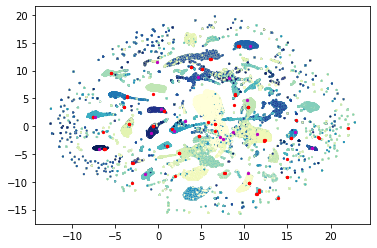

In [22]:
print(model.num_labels, model.device)
device = model.device
#if state.epoch >= 6 and state.epoch % 5 == 0:
model.eval()
x = []
samples = [[] for i in range(model.num_labels)]
p_per_class = int(model.num_prototypes/model.num_labels)

label = []

with torch.no_grad():
    for data in tqdm(dl, desc="obtaining hidden states"):
        # encoding data to hidden state - dim should be (N, D) - N batch size, D hidden vector dim
        inp = torch.t(torch.stack(data['input_ids']))
        #print(inp.shape)
        labels = torch.t(torch.stack(data.pop("labels")))
        outputs = model(input_ids=inp.to(device), attention_mask=torch.t(torch.stack(data['attention_mask'])).to(device))
        logits = outputs.logits[0].cpu()
        #print(logits.shape)
        # reversing one-hot encoding of the labels
        labs = (labels == 1).nonzero()

        #print(labs)
        labels = {}
        for l in labs:
            if l[0].item() in labels:
                labels[l[0].item()].append(l[1].item())
            else:
                labels[l[0].item()] = [l[1].item()]
        #print(labels)
        # adding each hidden state to its respective class' list
        for k, v in labels.items():
            for c in v:
                #print(c)
                x.append(logits[k, :])
                label.append(c)
                samples[c].append(inp[k,:])
    print('plotting data points')
    #print([len(x) for x in x_per_class])
    # projecting prototypes for each class
    print('prototypes:')
    for i in range(model.prototype_sample.data.size(0)):
        for j in range(model.prototype_sample.data.size(1)):
            with open(f'prototypes-red2-20-defs/_{i}_{j}.txt', 'w') as f:
                text = tokenizer.decode(model.prototype_sample.data[i,j,:].int())
                print(text)
                f.write(text)

    x = np.stack(x)
    labels = np.stack(label)
    
    prots = model.prototype_vectors.cpu()
    defs = model.roberta(model.definition_tokens).last_hidden_state[:,0,:].cpu()

plot_umap(x, labels, prots, 'prototype-red2-20-defs.pdf', defs)

In [23]:
trainer.predict(test_enc_1)

***** Running Prediction *****
  Num examples = 12920
  Batch size = 8


(array([[ 0.00612776, -0.01751041, -0.01067561, ...,  0.00593759,
        -0.01296386, -0.00827791],
       [ 0.00651562, -0.0001286 ,  0.01090471, ...,  0.00905988,
        -0.00634737,  0.01806834],
       [ 0.00611798, -0.01819659, -0.01044103, ...,  0.0054688 ,
        -0.01297284, -0.0077955 ],
       ...,
       [-0.01354856,  0.04275467,  0.00765482, ..., -0.01916385,
         0.03711161,  0.07625648],
       [-0.00756415,  0.04513722, -0.01191146, ..., -0.03920988,
         0.04371793,  0.04721699],
       [-0.01472308,  0.04868766,  0.00141949, ..., -0.02796606,
         0.05010223,  0.06613485]], dtype=float32), array([[-3.367 , -5.03  , -4.035 , ..., -4.555 , -4.684 , -4.438 ],
       [-1.042 , -4.78  , -0.626 , ..., -4.93  , -4.715 , -4.934 ],
       [-3.398 , -5.016 , -4.035 , ..., -4.535 , -4.664 , -4.414 ],
       ...,
       [-4.29  , -3.55  , -4.06  , ..., -4.27  , -1.133 , -4.348 ],
       [-4.332 ,  0.1843, -4.1   , ..., -4.176 , -3.146 , -4.266 ],
       [-4.305 , -

PredictionOutput(predictions=((array([[ 0.00612776, -0.01751041, -0.01067561, ...,  0.00593759,
        -0.01296386, -0.00827791],
       [ 0.00651562, -0.0001286 ,  0.01090471, ...,  0.00905988,
        -0.00634737,  0.01806834],
       [ 0.00611798, -0.01819659, -0.01044103, ...,  0.0054688 ,
        -0.01297284, -0.0077955 ],
       ...,
       [-0.01354856,  0.04275467,  0.00765482, ..., -0.01916385,
         0.03711161,  0.07625648],
       [-0.00756415,  0.04513722, -0.01191146, ..., -0.03920988,
         0.04371793,  0.04721699],
       [-0.01472308,  0.04868766,  0.00141949, ..., -0.02796606,
         0.05010223,  0.06613485]], dtype=float32), array([[-3.367 , -5.03  , -4.035 , ..., -4.555 , -4.684 , -4.438 ],
       [-1.042 , -4.78  , -0.626 , ..., -4.93  , -4.715 , -4.934 ],
       [-3.398 , -5.016 , -4.035 , ..., -4.535 , -4.664 , -4.414 ],
       ...,
       [-4.29  , -3.55  , -4.06  , ..., -4.27  , -1.133 , -4.348 ],
       [-4.332 ,  0.1843, -4.1   , ..., -4.176 , -3.146 

In [24]:
trainer.predict(test_enc_2)

***** Running Prediction *****
  Num examples = 12919
  Batch size = 8


(array([[-0.00869004,  0.04465127, -0.00494741, ..., -0.04012761,
         0.0397877 ,  0.07528445],
       [-0.0068031 ,  0.04383495, -0.01373913, ..., -0.03900977,
         0.04378328,  0.03743592],
       [-0.00960177,  0.0447429 , -0.00498559, ..., -0.03942889,
         0.04043939,  0.07566869],
       ...,
       [-0.02458019,  0.05524953,  0.03653644, ...,  0.07912773,
         0.05696801,  0.02276106],
       [ 0.00341366,  0.01152134, -0.00360106, ...,  0.01429536,
         0.00597908,  0.00563345],
       [ 0.00868131, -0.00422408,  0.002429  , ...,  0.00094204,
        -0.00729519, -0.00035911]], dtype=float32), array([[-4.457 , -3.475 , -4.266 , ..., -4.316 , -2.676 , -4.367 ],
       [-4.496 ,  1.637 , -4.24  , ..., -4.348 , -3.402 , -4.465 ],
       [-4.438 , -3.412 , -4.24  , ..., -4.285 , -2.63  , -4.332 ],
       ...,
       [-3.088 , -3.492 , -2.584 , ..., -2.955 , -3.336 ,  0.281 ],
       [-3.89  , -5.582 , -3.572 , ..., -5.547 , -5.4   , -5.242 ],
       [ 1.461 , -

PredictionOutput(predictions=((array([[-0.00869004,  0.04465127, -0.00494741, ..., -0.04012761,
         0.0397877 ,  0.07528445],
       [-0.0068031 ,  0.04383495, -0.01373913, ..., -0.03900977,
         0.04378328,  0.03743592],
       [-0.00960177,  0.0447429 , -0.00498559, ..., -0.03942889,
         0.04043939,  0.07566869],
       ...,
       [-0.02458019,  0.05524953,  0.03653644, ...,  0.07912773,
         0.05696801,  0.02276106],
       [ 0.00341366,  0.01152134, -0.00360106, ...,  0.01429536,
         0.00597908,  0.00563345],
       [ 0.00868131, -0.00422408,  0.002429  , ...,  0.00094204,
        -0.00729519, -0.00035911]], dtype=float32), array([[-4.457 , -3.475 , -4.266 , ..., -4.316 , -2.676 , -4.367 ],
       [-4.496 ,  1.637 , -4.24  , ..., -4.348 , -3.402 , -4.465 ],
       [-4.438 , -3.412 , -4.24  , ..., -4.285 , -2.63  , -4.332 ],
       ...,
       [-3.088 , -3.492 , -2.584 , ..., -2.955 , -3.336 ,  0.281 ],
       [-3.89  , -5.582 , -3.572 , ..., -5.547 , -5.4   

In [26]:
train_5 = load_dataset('json', data_files='data/red2/trainenc-5.json', split='train')
train_20 = load_dataset('json', data_files='data/red2/trainenc-20.json', split='train')
train_100 = load_dataset('json', data_files='data/red2/trainenc-100.json', split='train')

train_5, train_20, train_100

Using custom data configuration default-b43958e439dcc3bf


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Using custom data configuration default-4762cebe3660c3fe
Reusing dataset json (/home/14cfl/.cache/huggingface/datasets/json/default-4762cebe3660c3fe/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)


Dataset json downloaded and prepared to /home/14cfl/.cache/huggingface/datasets/json/default-b43958e439dcc3bf/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


Using custom data configuration default-79d5fabe8b80516e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/14cfl/.cache/huggingface/datasets/json/default-79d5fabe8b80516e/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 50567
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 90243
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 141237
 }))

In [25]:
plt.cm

<module 'matplotlib.cm' from '/home/14cfl/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/cm.py'>

# 